### In order to run CNN model, required files are to be downloaded from the link "http://www.dna.bio.keio.ac.jp/smiles/" as CNN based model is adapted from Hirohara et al. 
### Copy the downloaded files to a folder named "CNN_codes" and keep the "CNN_codes" folder in the folder "supp_scripts"

In [1]:
import os
os.system("mkdir ./CNN_codes")

mkdir: cannot create directory ‘./CNN_codes’: File exists


256

In [2]:
##############################################################################################
# Hirohara, M., Saito, Y., Koda, Y., Sato, K., Sakakibara, Y.:                               #
# Convolutional neural network based on smiles representation of compounds                   #
# for detecting chemical motif. BMC Bioinformatics 19 (2018). doi:10.1186/s12859-018-2523-5  #
##############################################################################################

# Downloading supporting files for the CNN model

! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/SCFPfunctions.py -P ./CNN_codes 
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/SCFPmodel.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/evaluate-CV.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/evaluate-challenge.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/feature.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/trainer-CV.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/trainer-challenge.py -P ./CNN_codes
! wget --quiet http://www.dna.bio.keio.ac.jp/smiles/README -P ./CNN_codes

In [16]:
#!/usr/bin/env python
# coding:utf-8

import copy
import sys
import tqdm
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

# custom functions
supp_script_path = './supp_scripts/'
sys.path.append(supp_script_path) # path for support scripts folder
sys.path.append(supp_script_path + 'CNN_codes/')
from feature import *
import SCFPfunctions as Mf

import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cpu'), False)

In [17]:
# To remove warnings
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [18]:
# Whole section is to read parameters from the parameter file
parameter_filename = "parameters_CNN.json" 
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file_train = parameters["input_file_train"] # input file
input_file_test = parameters["input_file_test"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

if not trial:
    run_folder = parameters["run_folder"]

gpu_id = int(parameters["gpu_id"])

gpu_id= None 
if gpu_id != None:
    device = "cuda:" + str(gpu_id)
else:
    gpu_id = 0

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

lensize = int(parameters["sequence_length_cutoff"]["lensize"]) # feature vector size
atomsize = int(parameters["sequence_length_cutoff"]["atomsize"]) # max length of molecule


learning_rate = float(parameters["network_parameters"]["learning_rate"])
epochs = int(parameters["network_parameters"]["epochs"])
batchsize = int(parameters["network_parameters"]["batchsize"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

# k = window size
# s = strides
# f = number of filters

# first convolution
k1 = int(parameters["conv1"]["k1"])
s1 = int(parameters["conv1"]["s1"])
f1 = int(parameters["conv1"]["f1"])

# max pooling 1 
k2 = int(parameters["pool1"]["k2"])
s2 = int(parameters["pool1"]["s2"])

# second convolution
k3 = int(parameters["conv2"]["k3"])
s3 = int(parameters["conv2"]["s3"])
f3 = int(parameters["conv2"]["f3"])

# max pooling 2
k4 = int(parameters["pool2"]["k4"])
s4 = int(parameters["pool2"]["s4"])

# number of hidden layers
n_hid = int(parameters["fc_layer_parameters"]["n_hid"])

os.system("mkdir " + str(run_folder))
if not trial:
    network_parameter_output = open(str(run_folder) + "/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

mkdir: cannot create directory ‘run_files_0.1’: File exists


In [19]:
# CNN network
class Net(nn.Module):
    def __init__(self, atomsize, lensize, k1, s1, f1, k2, s2, k3, 
                 s3, f3, k4, s4, n_hid, n_out):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, f1, (k1,lensize),padding=(k1//2,0),stride=(s1,s1))
        self.bn1 = nn.BatchNorm2d(f1)
        self.leakyr = nn.LeakyReLU()
        self.pool1 = nn.AvgPool2d((k2,1),stride=(s2,s2),padding=(k2//2,0))
        self.conv2 = nn.Conv2d(f1,f3,(k3,1),stride=(s3,s3),padding=(k3//2,0))
        self.bn2 = nn.BatchNorm2d(f3)
        self.pool2 = nn.AvgPool2d((k4,1),stride=(s4,s4),padding=(k4//2,0))
        self.maxpool = nn.MaxPool2d(kernel_size=2),
        self.fc1 = nn.Linear(f3, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn3 = nn.BatchNorm1d(n_hid)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.pool1(self.leakyr(self.bn1(self.conv1(x))))
        x = self.pool2(self.leakyr(self.bn2(self.conv2(x))))
        x = F.max_pool2d(x,kernel_size=x.size()[2:])
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.dropout(self.leakyr(x))
        x = self.fc2(x)
        return x

In [20]:
# Reading train_valid and test splits from the file and make it to a dataframe
smiles_label_test = {line.split()[0]:line.split()[1] for line in open(input_file_test,"r").readlines()}
smiles_label_test = dict(sorted(smiles_label_test.items(), key=lambda item: item[1]))

smiles_label_train = {line.split()[0]:line.split()[1] for line in open(input_file_train,"r").readlines()}
smiles_label_train = dict(sorted(smiles_label_train.items(), key=lambda item: item[1]))

train_valid_df = su.dict_to_label(smiles_label_train)
train_valid_df = train_valid_df
test_df = su.dict_to_label(smiles_label_test)
test_df = test_df.sample(frac=1).reset_index(drop=True)

n_out = len(set(test_df["Label"].to_list()))

In [33]:
train_valid_df

,Smiles,Label
0,C1CCCC12[C@H](O)C(=O)N(C(=O)C2)CCCC[NH+](CC3)C...,0
1,[O-]C(=O)CC[C@@H](C([O-])=O)NC(=O)c1ccc(s1)N(C...,0
2,C1C=CCC=C1[C@@H](N)C(=O)N[C@@H]2C(=O)N([C@@H]2...,0
3,[O-]C(=O)[C@@H](N)CSCC([O-])=O,0
4,c1ccccc1[C@H](CC(=O)C)c(c2=O)c(O)oc(c23)ccc(c3)O,0
...,...,...
548,c1cccc2C(C(=O)N)(c(c3c12)cccc3)CCC[NH2+]C(C)C,1
549,c1cccc(c12)[nH]c(=O)n2CCCN(CC3)CCC3n4c(=O)[nH]...,1
550,C1CCC[C@@H]([C@H]12)N([C@H](C([O-])=O)C2)C(=O)...,1
551,[O-]C(=O)c1c[nH]/c(s1)=N\C(=O)C(=C2[O-])N(C)S(...,1


In [21]:
# Increase the size of padding with maximum sequence length and a little
# Enable this if all molecules from the data has to be included
# else cutoff is taken, mentioned in the parameter file
max_sequence_length = max([len(smiles) for smiles in list(smiles_label_train)] + [len(smiles) for smiles in list(smiles_label_test)])
if max_sequence_length > atomsize:
    atomsize = (max_sequence_length+(100-(max_sequence_length%100))) + 100

Best model
LOSS train: 0.02158658974803984  val: 0.32448049262166023 	ACCU train: 0.998046875  val: 0.890625
Final model
LOSS train: 0.0008215178313548677  val: 0.5246233511716127 	ACCU train: 1.0  val: 0.921875


Best model
LOSS train: 0.05283940420486033  val: 0.30202658474445343 	ACCU train: 0.990234375  val: 0.9270833333333333
Final model
LOSS train: 0.0007461160294042202  val: 0.5345673151314259 	ACCU train: 1.0  val: 0.9427083333333333


Best model
LOSS train: 0.011870617629028857  val: 0.47535666450858116 	ACCU train: 1.0  val: 0.9270833333333333
Final model
LOSS train: 0.0012140782091591973  val: 1.0014810264110565 	ACCU train: 1.0  val: 0.875


Best model
LOSS train: 0.058065625140443444  val: 0.3130652457475662 	ACCU train: 0.984375  val: 0.8541666666666667
Final model
LOSS train: 0.0013666006980201928  val: 0.4303695783019066 	ACCU train: 1.0  val: 0.921875


Best model
LOSS train: 0.011947560240514576  val: 0.4133676141500473 	ACCU train: 1.0  val: 0.9375
Final model
LOSS train: 0.0006910279880685266  val: 0.6322512049227953 	ACCU train: 1.0  val: 0.9322916666666667


Best model
LOSS train: 0.12441323511302471  val: 0.37187568843364716 	ACCU train: 0.96875  val: 0.8229166666666667
Final model
LOSS train: 0.0008119676949718269  val: 0.5781198740005493 	ACCU train: 1.0  val: 0.9427083333333333


Best model
LOSS train: 0.1265683954115957  val: 0.3331339806318283 	ACCU train: 0.97265625  val: 0.9635416666666667
Final model
LOSS train: 0.0011765009639930213  val: 0.5454399678856134 	ACCU train: 1.0  val: 0.9427083333333333


Best model
LOSS train: 0.041677808621898293  val: 0.29021283239126205 	ACCU train: 0.998046875  val: 0.9114583333333333
Final model
LOSS train: 0.001797934528440237  val: 0.4734139256179333 	ACCU train: 1.0  val: 0.9270833333333333


Best model
LOSS train: 0.1619694740511477  val: 0.3837294653058052 	ACCU train: 0.958984375  val: 0.8697916666666667
Final model
LOSS train: 0.0009530530569463735  val: 0.9494045088067651 	ACCU train: 1.0  val: 0.9010416666666667


Best model
LOSS train: 0.029875250882469118  val: 0.31891781091690063 	ACCU train: 0.994140625  val: 0.8333333333333333
Final model
LOSS train: 0.000759248514441424  val: 0.6437617838382721 	ACCU train: 1.0  val: 0.9114583333333333


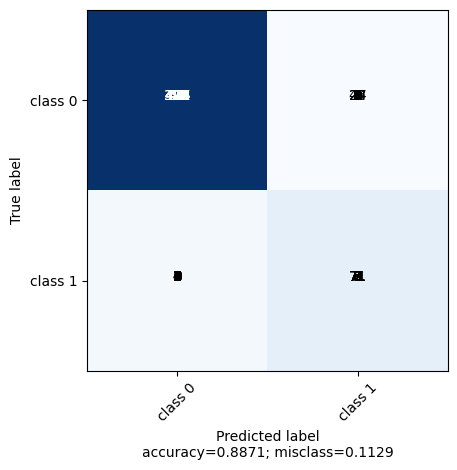

In [32]:
import torch

device = torch.device('cpu')

for fold in range(k_fold_value):
    
    if not trial:
        log_file = open(str(run_folder) + "/model_" + str(fold) + ".txt","w")
        model_output_name = str(run_folder) + "/model_" + str(fold) + ".pth"
    
    piece_count = fold + 1
    
    # create train and valid set for the fold
    train,valid,piece_count = su.CV.get_K_fold_cv_data(train_valid_df,k_fold_value,1,shuffle_output=True)
    
    # Make feature matrix for train, valid, test
    su.write_cid_smiles_output(train,"train_file.txt")
    x_train,y_train = su.CNN.make_grid("train_file.txt",lensize,atomsize)
    
    su.write_cid_smiles_output(valid,"valid_file.txt")
    x_valid,y_valid = su.CNN.make_grid("valid_file.txt",lensize,atomsize)
    
    su.write_cid_smiles_output(test_df,"test_file.txt")
    x_test,y_test = su.CNN.make_grid("test_file.txt",lensize,atomsize)

    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train)).to('cpu')
        if not trial:
            log_file.write("Class weight for loss (balancing weights) = " + str(class_weight) + "\n")

    # # calculate class_weight
    # if enable_class_weight:
    #     class_weight = torch.FloatTensor(su.get_class_weight(train)).cuda(gpu_id)
    #     if not trial:
    #         log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
    
    # Writing output
    if not trial:
        train_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_train])
        valid_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_valid])
        test_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_test])
        log_file.write("Training : Class distribution = " + str(train_class_distriution) + "\n")
        log_file.write("Valid : Class distribution = " + str(valid_class_distriution) + "\n")
        log_file.write("Test : Class distribution = " + str(test_class_distriution) + "\n")
    
    
    # Creating dataloader
    train_loader = su.CV.get_dataloader(x_train,y_train.squeeze(),batchsize)
    valid_loader = su.CV.get_dataloader(x_valid,y_valid.squeeze(),batchsize)
    test_loader = su.CV.get_dataloader(x_test,y_test.squeeze(),batchsize)
    
    
    # initializing network
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    if not trial:
        log_file.write("Epochs = " + str(epochs) + "\n")
        log_file.write("Learning rate = " + str(learning_rate) + "\n")
        log_file.write("optimizer = " + str("Adam") + "\n")
        log_file.write("criterion = " + str("CrossEntropyLoss") + "\n")
    
    
    # Training the network
    train_loss_list = []
    train_accu_list = []

    val_loss_list = []
    val_accu_list = []
    
    train_f1_list = []
    valid_f1_list = []
    if not trial:
        log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 

    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.CNN.train(model,criterion,optimizer,train_loader,device)
        val_loss,val_accu = su.CNN.validate(model,criterion,valid_loader,device)
        
        
        # For callback
        # Callback saves the best model based on the below priority
        # validation loss --> validation accuracy--> training loss--> training accuracy
        if epoch == 0: 
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1
        
        if epoch != 0:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                model_copy = copy.deepcopy(model)
                saved_model_id = epoch + 1
        
        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
    
    torch.save(model_copy.state_dict(), model_output_name)
    
    log_file.write("\nChosen model = epoch number " + str(saved_model_id))
    
    # Re-initializing the model for getting statistics for all the three sets of data for the current fold
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)

    if not trial: # classification report, loss, and accuracy for the datasets
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,train_loader,device)
        image_name = str(run_folder) + "/train_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,valid_loader,device)
        image_name = str(run_folder) + "/valid_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,test_loader,device)
        image_name = str(run_folder) + "/test_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
        
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("Used atomsize " + str(atomsize) + "\n")
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
        
    # best validation loss
    index = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    print ("Best model")
    print ("LOSS train:",train_loss_list[index]," val:",val_loss_list[index], "\tACCU train:",train_accu_list[index]," val:",val_accu_list[index])
    print ("Final model")    
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)